<a href="https://colab.research.google.com/github/jjgranadat/Semillero_SOFA/blob/C%C3%A9sar/knn_svm_kmeans_16qam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerías

In [38]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV

from scipy.io import loadmat

# Globales

In [39]:
def download_file(link):
    # Nombre del archivo
    file = link.split('/')[-1]
    
    # Descarga el archivo si no se ha hecho aún
    !if ! [[ -f "$file" ]]; then wget $link; fi;

    return file 

# Librería de funciones

In [40]:
LIB_LINK = "https://raw.githubusercontent.com/jjgranadat/Semillero_SOFA/C%C3%A9sar/sofa.py"
LIB_FILE = download_file(LIB_LINK)
import sofa

#Prueba de funciones

Lista larga: [6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5]
Lista corta y con ruido: [2.2, 2.9, 4.2, 5.1, 5.7, 7.3, 8.5, 1.2]


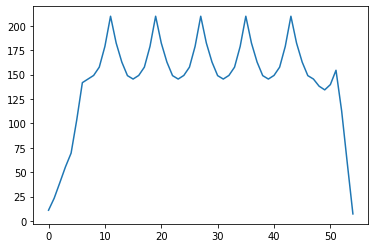

El índice es: 12, y la longitud de la señal es 8
El retraso es de 4 posiciones
Listas sincronizadas: ([2.2, 2.9, 4.2, 5.1, 5.7, 7.3, 8.5, 1.2], array([2, 3, 4, 5, 6, 7, 8, 1]))


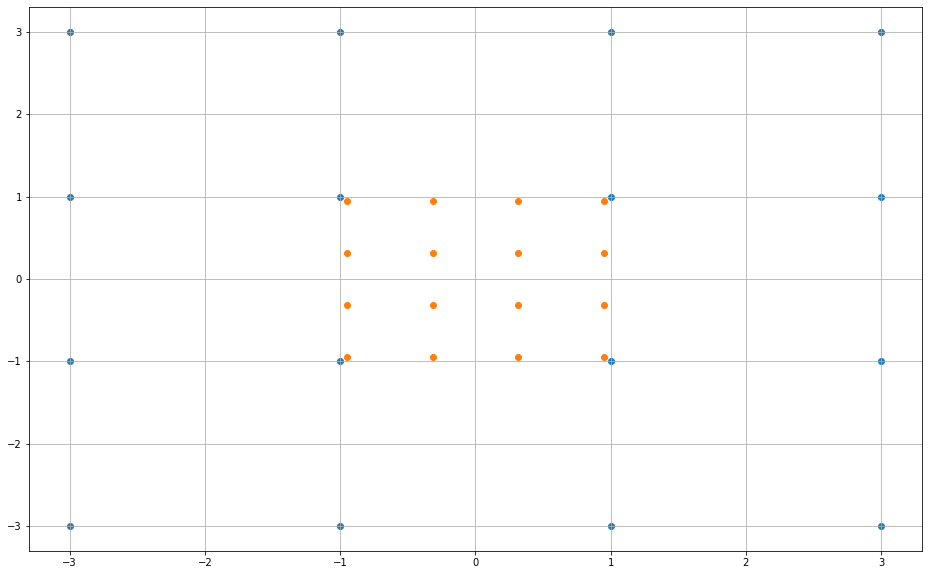

In [30]:
# Repetición de lista
lst1 = [6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5]
lst2 = [2.2, 2.9, 4.2, 5.1, 5.7, 7.3, 8.5, 1.2]

print(f"Lista larga: {lst1}")
print(f"Lista corta y con ruido: {lst2}")
print(f"Listas sincronizadas: {sofa.sync_signals(lst2, lst1)}")

# Normalzación
plt.figure(figsize = (16, 10))

values = np.array(list(sofa.MOD_DICT.values()))
plt.scatter(values.real, values.imag)

values_norm = sofa.mod_norm(values, 1)*values
plt.scatter(values_norm.real, values_norm.imag)

plt.grid(True)


# Datos experimentales

In [43]:
# Enlace del archivo (raw)
link_rx = "https://github.com/jjgranadat/Semillero_SOFA/raw/main/16QAM_3x16GBd_consY250km_00010.mat"
link_tx = "https://github.com/jjgranadat/Semillero_SOFA/raw/main/2x16QAM_16GBd.mat"

file_rx = download_file(link_rx)
X_ch_norm = loadmat(file_rx)
print(f"Las llaves de X_ch son: {X_ch_norm.keys()}")
X_ch_norm = X_ch_norm.get("const_Y").flatten()
X_ch = sofa.mod_norm(X_ch_norm, 10)*X_ch_norm
print(f"El tamaño de X_ch es: {X_ch_norm.shape}")

file_tx = download_file(link_tx)
X_tx_norm = loadmat(file_tx)
print(f"Las llaves de X_tx son: {X_tx_norm.keys()}")
X_tx_norm = X_tx_norm.get("Constellation").flatten()[0][1].flatten()
X_tx = sofa.mod_norm(X_tx_norm, 10)*X_tx_norm
print(f"El tamaño de X_tx es: {X_tx_norm.shape}")

Las llaves de X_ch son: dict_keys(['__header__', '__version__', '__globals__', 'const_Y'])
El tamaño de X_ch es: (108864,)
Las llaves de X_tx son: dict_keys(['__header__', '__version__', '__globals__', 'Constellation'])
El tamaño de X_tx es: (133152,)


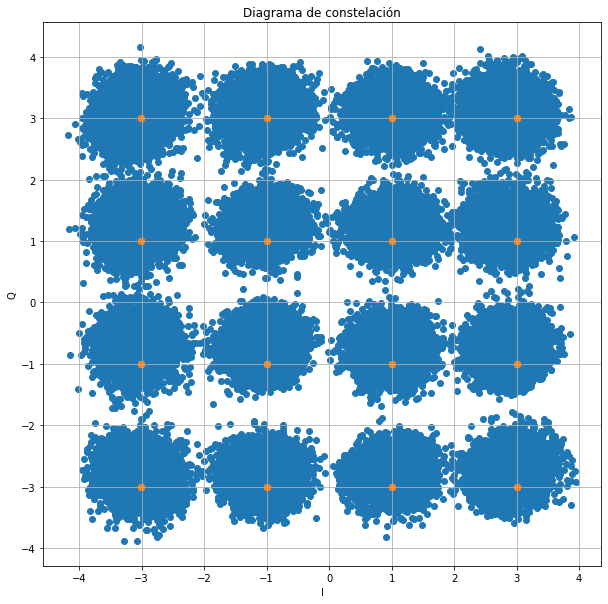

In [44]:
Xr_ch = X_ch.real
Xi_ch = X_ch.imag
Xr_tx = X_tx.real
Xi_tx = X_tx.imag

plt.figure(figsize = (10, 10))
plt.scatter(Xr_ch, Xi_ch)
plt.scatter(Xr_tx, Xi_tx)

# for symbol in np.unique(sym_tx):
#     ix = np.where(sym_tx == symbol)
#     plt.scatter(Xr_ch[ix], Xi_ch[ix], label = symbol, s = 100)

plt.title("Diagrama de constelación")
plt.xlabel("I")
plt.ylabel("Q")
plt.grid(True)
# plt.legend()

plt.show()

# Demodulación tradicional

In [45]:
def demodulate(X_rx, mod_dict):
    demodulated = []
    # Diccionario para demodular
    demod_dict = dict(zip(mod_dict.values(), mod_dict.keys()))
    for x in X_rx:
        # Distancia a cada centroide
        dist = np.abs(np.array(list(mod_dict.values())) - x)
        # Índice del valor mínimo de distancia
        index = list(dist).index(np.min(dist))
        # Centroide más cercano al símbolo
        demodulated.append(index)
    return np.array(demodulated)

# Demodulación usando KNN

In [46]:
def demodulate_knn(X_rx, sym_tx, k):
    X = np.array([X_rx.real, X_rx.imag]).T
    y = sym_tx
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
    
    # Número de vecinos
    model = KNeighborsClassifier(n_neighbors = k)
    model.fit(X_train, y_train)
    return model.predict(X)

# Demodulación usando SVM

In [47]:
def demodulate_svm(X_rx, sym_tx, C, gamma):
    X = np.array([X_rx.real, X_rx.imag]).T
    y = sym_tx
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

    model = SVC(C = C, gamma = gamma)
    model.fit(X_train, y_train)
    return model.predict(X)

# Demodulación usando K-means

In [48]:
def demodulate_kmeans(X_rx, mod_dict):
    X = list(zip(X_rx.real, X_rx.imag))
    A_mc = [(x.real, x.imag) for x in list(mod_dict.values())]
    model = KMeans(n_clusters = 16, n_init = 1, init = np.array(A_mc))
    model.fit(X)

    return model.predict(X)

# Encontrar los mejores parámetros para los algoritmos

In [49]:
def find_best_params(estimator, param_grid, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

    grid = GridSearchCV(estimator(), param_grid, verbose = 0)
    
    grid.fit(X_train, y_train)
    
    return grid.best_params_

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


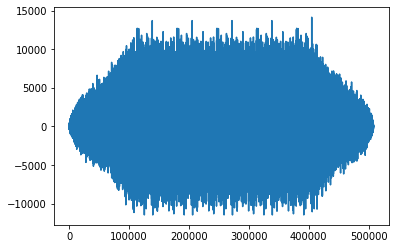

El índice es: 405090, y la longitud de la señal es 108864
El retraso es de 296226 posiciones
El error absoluto entre las señales sincronizadas es [7.08943287 4.41078511 4.76555741 3.89526643 2.25708438]


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


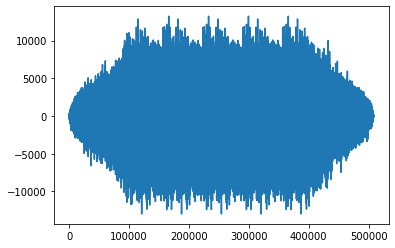

El índice es: 166267, y la longitud de la señal es 108864
El retraso es de 57403 posiciones
El error absoluto entre las señales sincronizadas es [6.17164511 2.4106903  2.52903202 1.90377466 5.68927946]


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


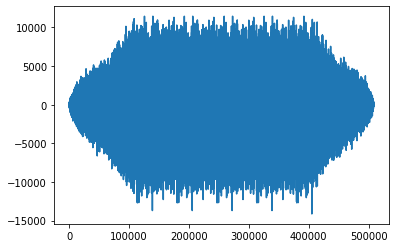

El índice es: 139585, y la longitud de la señal es 108864
El retraso es de 30721 posiciones
El error absoluto entre las señales sincronizadas es [2.7078085  5.80590012 2.51750058 7.42597157 5.68927946]


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


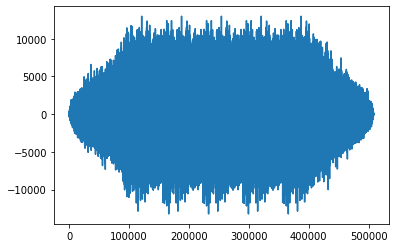

El índice es: 121104, y la longitud de la señal es 108864
El retraso es de 12240 posiciones
El error absoluto entre las señales sincronizadas es [4.32327614 5.80590012 2.51750058 8.64487093 2.25708438]
[(0.9367100235155791, 101974), (0.9363793356848913, 101938), (0.9359751616696061, 101894), (0.9365171222810111, 101953)]
[(0.9367559523809523, 101979), (0.9364620076425632, 101947), (0.936085390946502, 101906), (0.9364528218694885, 101946)]


In [50]:
X = X_ch.T
kmeans_ser = []
trad_ser = []
for ph in range(4):
    # Constelación recibida rotada
    rotated_X = X_ch*np.exp(ph*1j*np.pi/2)
    # Sincronización de las señales
    rotated_X, synced_X_tx = sofa.sync_signals(rotated_X, X_tx)
    print(f"El error absoluto entre las señales sincronizadas es {np.abs(rotated_X[:5] - synced_X_tx[:5])}")
    # Se demodula la señal transmitida
    y = demodulate(synced_X_tx, sofa.MOD_DICT)
    # Demodulación de la recibida rotada
    kmeans = demodulate_kmeans(rotated_X, sofa.MOD_DICT)
    trad = demodulate(rotated_X, sofa.MOD_DICT)
    # BER de la demodulación con respecto a la transmitida desplazada
    kmeans_ser.append(sofa.symbol_error_rate(kmeans, y))
    trad_ser.append(sofa.symbol_error_rate(trad, y))

print(kmeans_ser)
print(trad_ser)
# Probar la correlación con los datos sin demodular
# Probar girando 90° la constelación recibida

#Falsificación del modelo real

El verdadero retraso es de 2726 posiciones


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


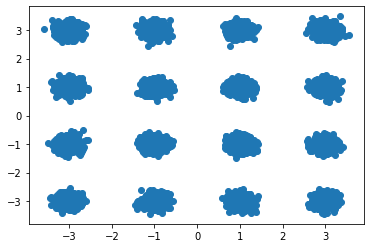

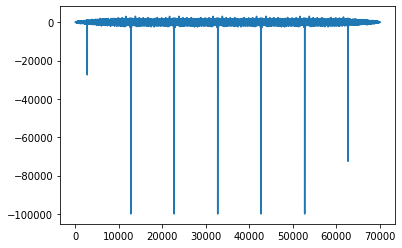

El índice es: 13793, y la longitud de la señal es 10000
El retraso es de 3793 posiciones
El error absoluto entre las señales sincronizadas es [2.14840004 2.69789485 3.91594125 0.25648283 0.17690628]
[ 0 13 11  5  4]


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


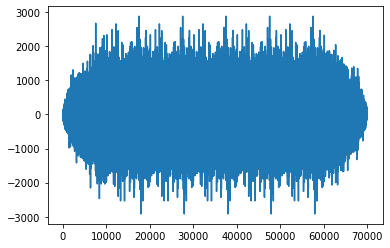

El índice es: 17541, y la longitud de la señal es 10000
El retraso es de 7541 posiciones
El error absoluto entre las señales sincronizadas es [5.46114974 5.99392439 4.3618419  2.57195374 0.17690628]
[12  2 13  1  3]


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


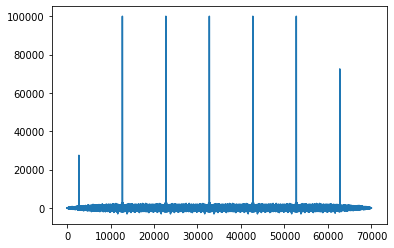

El índice es: 12726, y la longitud de la señal es 10000
El retraso es de 2726 posiciones
El error absoluto entre las señales sincronizadas es [0.19589016 0.17987466 0.11471446 0.25648283 0.17690628]
[14  2  2 15 14]


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


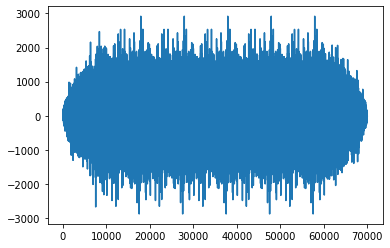

El índice es: 17911, y la longitud de la señal es 10000
El retraso es de 7911 posiciones
El error absoluto entre las señales sincronizadas es [5.8693098  5.99392439 6.21983786 4.71551705 2.66910787]
[ 1  8  3  0 12]
[(0.9356, 9356), (0.9357, 9357), (0.0, 0), (0.9357, 9357)]
[(0.9356, 9356), (0.9357, 9357), (0.0, 0), (0.9357, 9357)]


In [42]:
# Crear datos aleatorios
# Número de símbolos
Ns = 10000
# 16-QAM
Mod = 16
sym_tx = np.random.randint(Mod, size = Ns)

# Ahora se concatena 3 veces el array (simulando que sea infinito)
sym_tx_inf = np.concatenate((sym_tx, sym_tx))

# Ahora se tomará la longitud Ns del arreglo infinito desde un índice aleatorio
rand_index = np.random.randint(1, Ns*2 - 1)
print(f"El verdadero retraso es de {Ns - rand_index} posiciones")
sym_rx_pure = sym_tx_inf[rand_index:rand_index + Ns]

# Se modulará tanto la transmitida como la recibida
X_rx_pure = np.array([sofa.MOD_DICT[sym] for sym in sym_rx_pure])
X_tx = np.array([sofa.MOD_DICT[sym] for sym in sym_tx_inf])

snr = 24
X_ch_r, X_ch_i = sofa.add_awgn(snr, X_rx_pure)
X_ch = X_ch_r + 1j*X_ch_i

# Ahora finalmente se rotará la constelación
X_ch = X_ch*np.exp(2*1j*np.pi/2)

# Se grafica la constelación resultante
plt.scatter(X_ch.real, X_ch.imag)

# Se procede entonces a demodular (hacer el procedimiento inverso)
X = X_ch.T
kmeans_ser = []
trad_ser = []
for ph in range(4):
    # Constelación recibida rotada
    rotated_X = X_ch*np.exp(ph*1j*np.pi/2)
    # Sincronización de las señales
    rotated_X, synced_X_tx = sofa.sync_signals(rotated_X, X_tx)
    print(f"El error absoluto entre las señales sincronizadas es {np.abs(rotated_X[:5] - synced_X_tx[:5])}")
    # Se demodula la señal transmitida
    y = demodulate(synced_X_tx, sofa.MOD_DICT)
    print(y[:5])
    # Demodulación de la recibida rotada
    kmeans = demodulate_kmeans(rotated_X, sofa.MOD_DICT)
    trad = demodulate(rotated_X, sofa.MOD_DICT)
    # BER de la demodulación con respecto a la transmitida desplazada
    kmeans_ser.append(sofa.symbol_error_rate(kmeans, y))
    trad_ser.append(sofa.symbol_error_rate(trad, y))

print(kmeans_ser)
print(trad_ser)
# Probar la correlación con los datos sin demodular
# Probar girando 90° la constelación recibida

In [ ]:
for key in sofa.MOD_DICT:
    print(key, sofa.MOD_DICT[key])

0 (-3+3j)
1 (-3+1j)
2 (-3-3j)
3 (-3-1j)
4 (-1+3j)
5 (-1+1j)
6 (-1-3j)
7 (-1-1j)
8 (3+3j)
9 (3+1j)
10 (3-3j)
11 (3-1j)
12 (1+3j)
13 (1+1j)
14 (1-3j)
15 (1-1j)


In [ ]:
def sync_signals(short_signal, long_signal):
    # Se concatena para asegurar de que el array recibido esté contenido dentro
    # del largo.
    longer_signal = np.concatenate((long_signal, long_signal, long_signal))
    correlation = np.correlate(short_signal, longer_signal, mode="full")
    plt.figure()
    plt.plot(correlation)
    plt.show()
    index = np.argmax(correlation) + 1
    print(f"El índice es: {index}, y la longitud de la señal es {len(short_signal)}")
    delay = index - len(short_signal)
    print(f"El retraso es de {delay} posiciones")

    sync_signal = np.roll(longer_signal, delay)
    sync_signal = sync_signal[: len(short_signal)]

    return short_signal, sync_signal

sofa.sync_signals = sync_signals